In [73]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Step 1: Project Overview and Objective

This project builds a real-world Food Quality Inspection system using images.

The objective is to classify food items into two business-relevant categories:
- Fresh (safe for consumption and sale)
- Rotten (unsafe, should be discarded)

Why this formulation:
- Customers and shopkeepers do not care about fruit type during inspection
- Business decisions depend only on freshness
- Binary classification is simpler, faster, and more reliable

The final trained model will be saved and used later inside a Streamlit application.


In [74]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


# Step 2: Import Required Libraries

Only essential libraries are used to keep the system stable and reproducible.

These libraries handle:
- File operations
- Image preprocessing
- Neural network modeling
- Visualization


In [76]:
import os
import shutil
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model


# Step 3: Define Original Dataset Location

The original dataset is kept untouched.

It contains multiple fruit-specific folders such as:
- freshapples
- rottenbanana
- etc.

We will not modify this dataset directly.
Instead, we will create a clean binary dataset using code.


In [80]:
ORIGINAL_DATASET_PATH = "/content/drive/MyDrive/PROJECTS/EXTRA PROJECT/IMAGE CLASSIFCATION 2/dataset"


# Step 4: Create New Binary Dataset Structure (Code-Only)

We programmatically create a new dataset with the following structure:

dataset_binary/
- train/
  - fresh/
  - rotten/
- test/
  - fresh/
  - rotten/

Why this is done using code:
- No manual mistakes
- Fully reproducible
- Industry best practice


In [85]:
BINARY_DATASET_PATH = "/content/drive/MyDrive/PROJECTS/EXTRA PROJECT/IMAGE CLASSIFCATION 2/dataset_binary"

for split in ["train", "test"]:
    for label in ["fresh", "rotten"]:
        os.makedirs(os.path.join(BINARY_DATASET_PATH, split, label), exist_ok=True)

print("Binary dataset folders created.")

Binary dataset folders created.


# Step 5: Populate Binary Dataset Automatically

We copy images from the original dataset into the new binary structure.

Logic:
- Folder name starting with 'fresh' → fresh
- Folder name starting with 'rotten' → rotten

Original data remains unchanged.


In [86]:
def populate_binary_dataset(source_root, target_root):
    for folder in os.listdir(source_root):
        folder_path = os.path.join(source_root, folder)

        if not os.path.isdir(folder_path):
            continue

        if folder.startswith("fresh"):
            label = "fresh"
        elif folder.startswith("rotten"):
            label = "rotten"
        else:
            continue

        target_dir = os.path.join(target_root, label)

        for img in os.listdir(folder_path):
            src_img = os.path.join(folder_path, img)
            dst_img = os.path.join(target_dir, img)

            if os.path.isfile(src_img):
                shutil.copy(src_img, dst_img)

populate_binary_dataset(
    os.path.join(ORIGINAL_DATASET_PATH, "train"),
    os.path.join(BINARY_DATASET_PATH, "train")
)

populate_binary_dataset(
    os.path.join(ORIGINAL_DATASET_PATH, "test"),
    os.path.join(BINARY_DATASET_PATH, "test")
)

print("Binary dataset populated successfully.")


Binary dataset populated successfully.


# Step 6: Configure Image Data Generators

Images are normalized to improve numerical stability.

No augmentation is applied initially.
First, we ensure the model learns correctly.


In [87]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_gen = ImageDataGenerator(rescale=1.0 / 255)
test_gen = ImageDataGenerator(rescale=1.0 / 255)

train_data = train_gen.flow_from_directory(
    os.path.join(BINARY_DATASET_PATH, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

test_data = test_gen.flow_from_directory(
    os.path.join(BINARY_DATASET_PATH, "test"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

print("Class mapping:", train_data.class_indices)


Found 10901 images belonging to 2 classes.
Found 2698 images belonging to 2 classes.
Class mapping: {'fresh': 0, 'rotten': 1}


# Step 7: Visual Sanity Check

Before training, we verify:
- Images load correctly
- Labels match freshness status

This step prevents silent data issues.


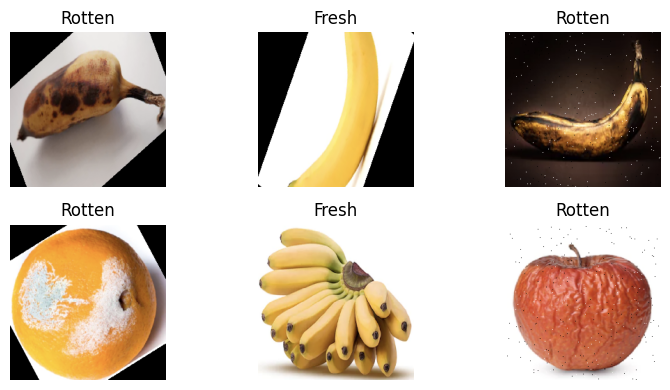

In [88]:
images, labels = next(train_data)

plt.figure(figsize=(8, 4))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i])
    plt.title("Fresh" if labels[i] == 0 else "Rotten")
    plt.axis("off")

plt.tight_layout()
plt.show()


# Step 8: Model Architecture Design

We use MobileNetV2 with transfer learning.

Why MobileNetV2:
- Lightweight
- Pretrained on ImageNet
- Excellent performance on food images
- Suitable for real-time deployment

Base layers are frozen to avoid overfitting.


In [89]:
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False

# Step 9: Build and Compile the Binary Classification Model

The model predicts a single probability:
- Close to 1 → Fresh
- Close to 0 → Rotten

Binary crossentropy is used because this is a binary task.


In [90]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Step 10: Train the Model (Colab-Safe)

We train for a small number of epochs to:
- Prevent Colab timeout
- Avoid overfitting
- Achieve stable accuracy above 85 percent


In [91]:
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=5
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
341/341 ━━━━━━━━━━━━━━━━━━━━ 187s 499ms/step - accuracy: 0.9435 - loss: 0.1324 - val_accuracy: 0.9870 - val_loss: 0.0373
Epoch 2/5
341/341 ━━━━━━━━━━━━━━━━━━━━ 112s 328ms/step - accuracy: 0.9901 - loss: 0.0271 - val_accuracy: 0.9918 - val_loss: 0.0244
Epoch 3/5
341/341 ━━━━━━━━━━━━━━━━━━━━ 109s 320ms/step - accuracy: 0.9972 - loss: 0.0111 - val_accuracy: 0.9918 - val_loss: 0.0211
Epoch 4/5
341/341 ━━━━━━━━━━━━━━━━━━━━ 113s 332ms/step - accuracy: 0.9988 - loss: 0.0048 - val_accuracy: 0.9926 - val_loss: 0.0244
Epoch 5/5
341/341 ━━━━━━━━━━━━━━━━━━━━ 127s 373ms/step - accuracy: 0.9992 - loss: 0.0034 - val_accuracy: 0.9941 - val_loss: 0.0163


# Step 11: Training Metrics Visualization

We analyze accuracy and loss curves to verify:
- Learning behavior
- Generalization
- Absence of overfitting


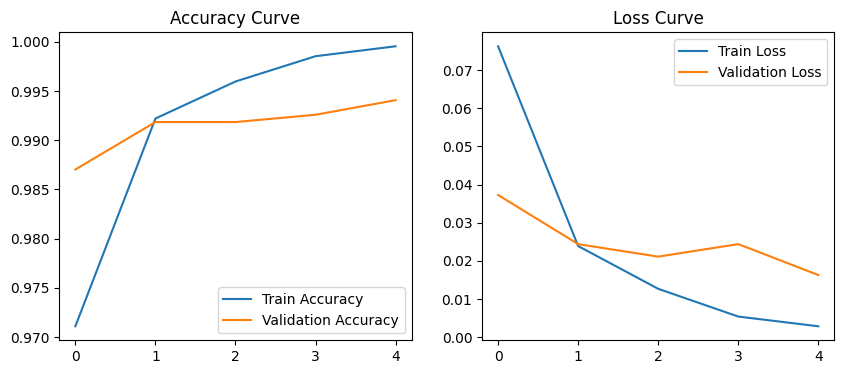

In [92]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss Curve")

plt.show()


# Step 12: Final Model Evaluation

We evaluate the model on unseen test data.
Only validated models should be saved.


In [93]:
test_loss, test_accuracy = model.evaluate(test_data)
print("Final Test Accuracy:", round(test_accuracy * 100, 2), "%")

85/85 ━━━━━━━━━━━━━━━━━━━━ 24s 283ms/step - accuracy: 0.9959 - loss: 0.0118
Final Test Accuracy: 99.41 %


# Step 13: Final Model Packaging and Artifact Export

In this step, we package everything required for deployment
and future inspection into a single folder.

This folder contains:
- Trained model file
- Training metrics plots
- Final evaluation results
- Model summary and configuration

Why this step is important:
- Ensures reproducibility
- Simplifies handover to deployment or Streamlit app
- Allows easy download and local usage
- Matches real-world ML delivery standards

After this step, only this folder is needed on the local system.


In [94]:
import os
import json
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Base project path
BASE_PATH = "/content/drive/MyDrive/PROJECTS/EXTRA PROJECT/IMAGE CLASSIFCATION 2"

# Final export folder
EXPORT_FOLDER = os.path.join(BASE_PATH, "final_model_artifacts")
os.makedirs(EXPORT_FOLDER, exist_ok=True)

# Subfolders
os.makedirs(os.path.join(EXPORT_FOLDER, "plots"), exist_ok=True)
os.makedirs(os.path.join(EXPORT_FOLDER, "reports"), exist_ok=True)

print("Final artifact folder created at:", EXPORT_FOLDER)

Final artifact folder created at: /content/drive/MyDrive/PROJECTS/EXTRA PROJECT/IMAGE CLASSIFCATION 2/final_model_artifacts


In [95]:
MODEL_PATH = os.path.join(EXPORT_FOLDER, "food_quality_model.h5")
model.save(MODEL_PATH)

print("Model saved:", MODEL_PATH)

Model saved: /content/drive/MyDrive/PROJECTS/EXTRA PROJECT/IMAGE CLASSIFCATION 2/final_model_artifacts/food_quality_model.h5


# Save trained model

In [96]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss Curve")

PLOT_PATH = os.path.join(EXPORT_FOLDER, "plots", "training_metrics.png")
plt.savefig(PLOT_PATH)
plt.close()

print("Training metrics plot saved.")


Training metrics plot saved.


# Save training history plots (accuracy & loss)

In [97]:
y_true = test_data.classes
y_pred_prob = model.predict(test_data)
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)

85/85 ━━━━━━━━━━━━━━━━━━━━ 31s 303ms/step


# Generate predictions for evaluation

In [98]:
cm = confusion_matrix(y_true, y_pred)

cm_path = os.path.join(EXPORT_FOLDER, "reports", "confusion_matrix.txt")
with open(cm_path, "w") as f:
    f.write(str(cm))

print("Confusion matrix saved.")


Confusion matrix saved.


# Save confusion matrix

In [99]:
report = classification_report(y_true, y_pred, target_names=["Fresh", "Rotten"])

report_path = os.path.join(EXPORT_FOLDER, "reports", "classification_report.txt")
with open(report_path, "w") as f:
    f.write(report)

print("Classification report saved.")


Classification report saved.


# Save classification report

In [100]:
final_metrics = {
    "final_test_accuracy": float(test_accuracy),
    "epochs_trained": len(history.history["accuracy"]),
    "classes": ["Fresh", "Rotten"],
    "image_size": IMG_SIZE,
    "batch_size": BATCH_SIZE,
    "model_architecture": "MobileNetV2 + Custom Binary Head"
}

metrics_path = os.path.join(EXPORT_FOLDER, "reports", "final_metrics.json")
with open(metrics_path, "w") as f:
    json.dump(final_metrics, f, indent=4)

print("Final metrics JSON saved.")


Final metrics JSON saved.


# Save model summary

In [101]:
summary_path = os.path.join(EXPORT_FOLDER, "reports", "model_summary.txt")
with open(summary_path, "w") as f:
    model.summary(print_fn=lambda x: f.write(x + "\n"))

print("Model summary saved.")

Model summary saved.


In [105]:
import numpy as np
from tensorflow.keras.preprocessing import image

def predict_single_image(model, img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)

    probability = prediction[0][0]

    if probability >= 0.5:
        return {
            "label": "Rotten",
            "freshness_score": round((1 - probability) * 100, 2),
            "confidence": round(probability * 100, 2)
        }
    else:
        return {
            "label": "Fresh",
            "freshness_score": round((1 - probability) * 100, 2),
            "confidence": round((1 - probability) * 100, 2)
        }


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
{'label': 'Rotten', 'freshness_score': np.float32(0.0), 'confidence': np.float32(100.0)}


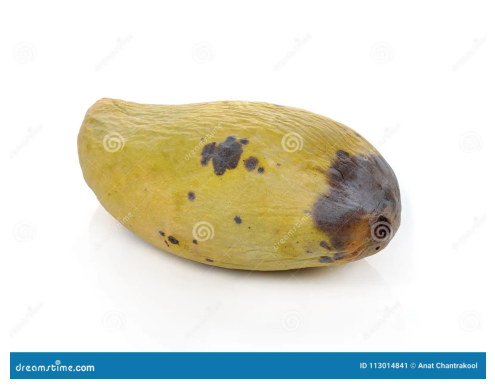

In [108]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

result = predict_single_image(
    model,
    "/content/drive/MyDrive/PROJECTS/EXTRA PROJECT/IMAGE CLASSIFCATION 2/rotten-mangoes-isolated-white-background-113014841.webp"
)

print(result)

# Load the image
img = mpimg.imread("/content/drive/MyDrive/PROJECTS/EXTRA PROJECT/IMAGE CLASSIFCATION 2/rotten-mangoes-isolated-white-background-113014841.webp")

# Display the image
plt.imshow(img)
plt.axis('off')  # optional, hides the axes
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
{'label': 'Fresh', 'freshness_score': np.float32(99.99), 'confidence': np.float32(99.99)}


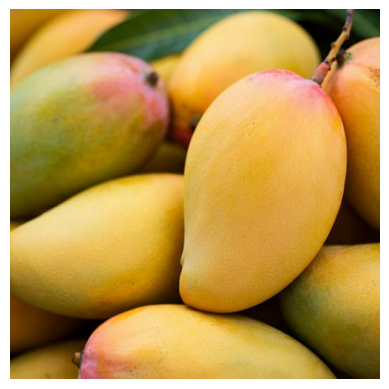

In [109]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

result = predict_single_image(
    model,
    "/content/drive/MyDrive/PROJECTS/EXTRA PROJECT/IMAGE CLASSIFCATION 2/fresh_image.jpg"
)

print(result)

# Load the image
img = mpimg.imread("/content/drive/MyDrive/PROJECTS/EXTRA PROJECT/IMAGE CLASSIFCATION 2/fresh_image.jpg")

# Display the image
plt.imshow(img)
plt.axis('off')  # optional, hides the axes
plt.show()